In [128]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [129]:
def read_txt(filepath):
    df = pd.read_csv(filepath, sep=" ", header=None)
    df[0] = df[0].apply(lambda x: x[1:-1])
    df[0] = df[0].apply(lambda x: x.replace("\'",""))
    df[1] = df[1].apply(lambda x: int(x[0:-1]))
    print(df.head(5))
    return df

In [130]:
class Classifier:

    def __init__(self, arr_ign, thresh=.001):
        """
        Initialize classifier
        """
        self.threshold = thresh
        self.dis_words = {}
        self.non_words = {}
        self.ign_words = arr_ign
        self._y = None
        self.label_to_index = None
        self.index_to_label = None

    def tokenizeString(self, tweet):
        wordsInTweet = []
        currWord = ""
        for i in tweet:
            if(i == ' ' or i == '.' or i == '?' or i == '!'):
                wordsInTweet.append(currWord)
                currWord = ""
            else:
                currWord += i
        return wordsInTweet
        
    def fit(self, X, y):
        """
        Fit the model using the provided data
        :param X: 2-D np.array of shape (number training samples,)
        :param y: 1-D np.array of shape (number training samples,)
        :return: self
        """
        for i in range(len(X)):
            words = self.tokenizeString(X[i])
            for j in words:
                if j not in self.ign_words:
                    if y[i]:
                        if j in self.dis_words:
                            self.dis_words[j] += 1
                        else:
                            self.dis_words[j] = 1
                    else:
                        if j in self.non_words:
                            self.non_words[j] += 1
                        else:
                            self.non_words[j] = 1
        
        del_keys = []
        for k,v in self.dis_words.items():
            if k in self.non_words:
                del_keys.append(k)
        for k in del_keys:
            self.dis_words.pop(k)
            self.non_words.pop(k)
        
        min_val = self.threshold*len(X)
        
        del_keys = []
        for k,v in self.dis_words.items():
            if v < min_val:
                del_keys.append(k)
        for k in del_keys:
            self.dis_words.pop(k)
        
        del_keys = []
        for k,v in self.non_words.items():
            if v < min_val:
                del_keys.append(k)
        for k in del_keys:
            self.non_words.pop(k)
        
        self._y = y

        return self
    

    def predict(self, X):
        """
        Given new data points, classify them according to the training data provided in fit and number of neighbors k
        You should use BallTree to get the distances and indices of the nearest k neighbors
        :param X: feature vectors (num_points, num_features)
        :return: 1-D np.array of predicted classes of shape (num_points,)
        """
        ls_exp = []
        for i in range(len(X)):
            words = self.tokenizeString(X[i])
            exp = 0
            for k,v in self.dis_words.items():
                if k in words:
                    exp += 1
            for k,v in self.non_words.items():
                if k in words:
                    exp -= 1
            ls_exp.append(exp)
        
        ls_prob = []
        ls_pred = []
        for i in range(len(ls_exp)):
            prob = 1 / (1 + (np.exp(-1*ls_exp[i])))
            ls_prob.append(prob)
            if prob > .5:
                ls_pred.append(1)
            else:
                ls_pred.append(0)
#         print(ls_prob)
#         print(ls_pred)
        
        return np.array(ls_pred)

    def accuracy(self, pred, y):
        """
        Return the accuracy of the classifier on the data (X_test, y_test)
        :param X: np.array of shape (m, number_features)
        :param y: np.array of shape (m,)
        :return: accuracy score [float in (0,1)]
        """
        score = (len(pred) - np.sum(np.absolute(pred-y)))/len(pred)
        return score

In [137]:
def create_sets(X, y, test_size=1200):
    test_ind = np.random.choice(range(len(X)), test_size, replace=False)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(len(X)):
        if i in test_ind:
            X_test.append(X[i])
            y_test.append(y[i])
        else:
            X_train.append(X[i])
            y_train.append(y[i])
            
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test
            

In [138]:
df = pd.read_csv('./data/train.csv')
X = np.array(df['text'])
y = np.array(df['target'])
df_ign = pd.read_csv("./data/ignoreWords.txt", sep=" ", header=None)
arr_ign = np.array(df_ign[0])

In [139]:
X_train, y_train, X_test, y_test = create_sets(X, y)

In [145]:
model = Classifier(arr_ign, thresh=.0001)
fitted_model = model.fit(X_train,y_train)
pred = fitted_model.predict(X_train)
fitted_model.accuracy(pred, y_train)

0.9758303446125058

In [149]:
model = Classifier(arr_ign, thresh=.0001)
fitted_model = model.fit(X_train,y_train)

In [150]:
train = []
test = []
for i in range(5):
    thresh = 1/(10**i)
    print(thresh)
    model = Classifier(arr_ign, thresh=thresh)
    fitted_model = model.fit(X_train,y_train)
    pred = fitted_model.predict(X_train)
    acc_train = fitted_model.accuracy(pred, y_train)
    
    pred_test = fitted_model.predict(X_test)
    acc_test = fitted_model.accuracy(pred_test, y_test)
    
    train.append(acc_train)
    test.append(acc_test)
    

1.0
0.1
0.01
0.001
0.0001


In [151]:
print(train)
print(test)

[0.5722750662716357, 0.5722750662716357, 0.5722750662716357, 0.7146421331670045, 0.9758303446125058]
[0.56, 0.56, 0.56, 0.6833333333333333, 0.7425]


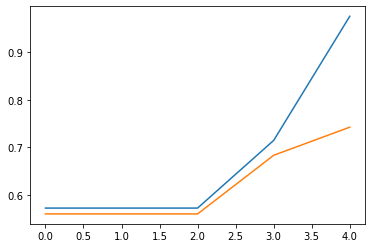

In [152]:
plt.plot(train)
plt.plot(test)